# 1. 고양이 스티커 붙이기

In [25]:
#!pip install cmake opencv-python
#!conda install -y dlib

In [3]:
import os 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import dlib 

print(cv2.__version__)
print(dlib.__version__)

4.12.0
20.0.0


In [4]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/project/Exploration/Quest03/project_image/image.JPG') 
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()     
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

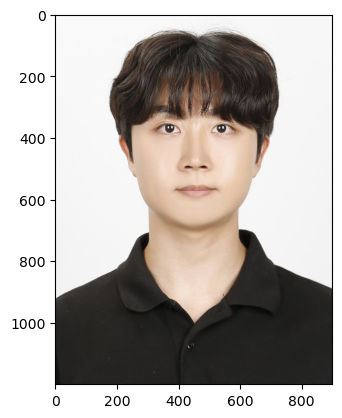

In [5]:
plt.imshow(img_rgb)

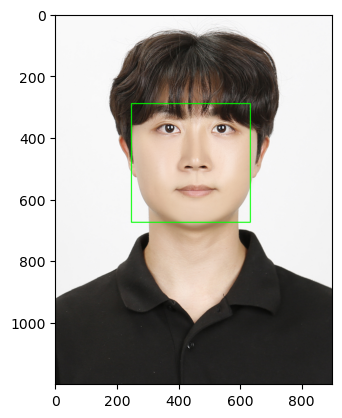

In [6]:
detector_hog = dlib.get_frontal_face_detector() 

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
dlib_rects = detector_hog(img_rgb, 1)

for dlib_rect in dlib_rects: 
    l = dlib_rect.left() 
    t = dlib_rect.top()
    r = dlib_rect.right() 
    b = dlib_rect.bottom() 

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
model_path = os.path.join(home_dir, 'work/project/Exploration/Quest03/camera_sticker/models/shape_predictor_68_face_landmarks.dat')
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


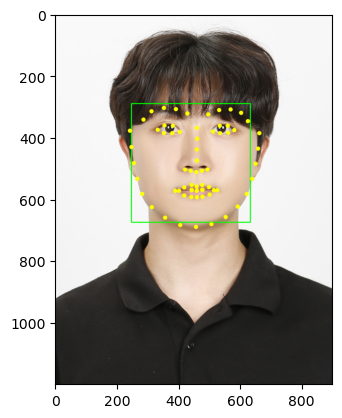

In [8]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 7, (0, 255, 255), -1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 실제 고양이를 보면 코 끝(33번)보다는 코와 윗입술 사이인 인중을 기준으로 하면 좋을 거 같다. 
- 근데 랜드마크 point를 보면 인중이 없다. 
- 그렇기에 코끝(33번)과 윗입술 가운데(51번)의 중앙값을 point로 하면 될 거 같다.

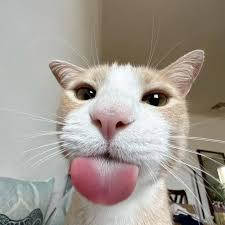

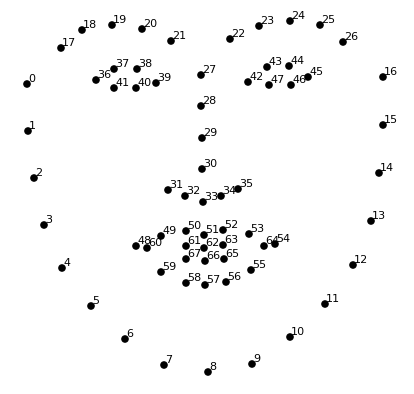

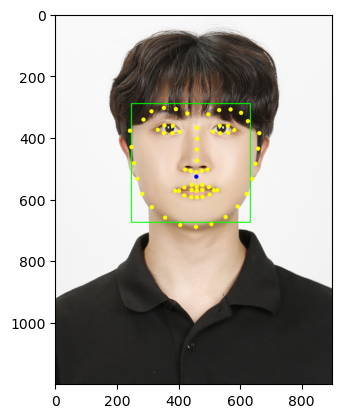

In [11]:
# 인중 중심점 계산
def get_philtrum_center(landmarks):
    p33 = landmarks[33]  # 코 끝 (457, 512)
    p51 = landmarks[51]  # 윗입술 중심 (458, 559)
    x_philtrum = p33[0]  # 457
    y_philtrum = p33[1] + (p51[1] - p33[1]) / 3  # 512 + (559-512)/3
                                                 # 2로 나누면 너무 인중 중앙이라 3으로
                                                 # 527.6666666666666
    return (x_philtrum, y_philtrum)

for landmarks in list_landmarks:
    x, y = get_philtrum_center(landmarks)
    cv2.circle(img_show, (int(x), int(y)), 7, (255, 0, 0), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [12]:
w = h = dlib_rect.width()

sticker_path = os.path.join(home_dir, 'work/project/Exploration/Quest03/project_image/cat-whiskers.png')
img_sticker = cv2.imread(sticker_path) 
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape) 

(386, 386, 3)


In [14]:
img_bgr.shape[:2]

(1200, 900)

In [15]:
# 스티커를 위치 계산
# x, y = 457, 527.6666666666666
# w, h = 386, 386
# y1: 스티커의 상단 시작 위치 (중심에서 높이의 절반만큼 위로 이동)
# x1: 스티커의 왼쪽 시작 위치 (중심에서 너비의 절반만큼 왼쪽으로 이동)
# y2: 스티커의 하단 끝 위치 (시작점 y1에서 높이 h만큼 아래로)
# x2: 스티커의 오른쪽 끝 위치 (시작점 x1에서 너비 w만큼 오른쪽으로)
y1 = int(y - h // 2)   # 527.67 - (386 // 2) = 527.67 - 193 = 334.67 → 334
x1 = int(x - w // 2)   # 457 - (386 // 2) = 457 - 193 = 264
y2 = y1 + h            # 334 + 386 = 720
x2 = x1 + w            # 264 + 386 = 650

img_h, img_w = img_bgr.shape[:2] # (1200, 900)

# 스티커가 이미지 경계를 벗어나는 경우 대비 (Clipping)
roi_y1 = max(0, y1)  # 스티커의 y1이 0보다 작으면 0으로 보정
roi_x1 = max(0, x1)  # 스티커의 x1이 0보다 작으면 0으로 보정
roi_y2 = min(img_h, y2)  # 스티커의 y2가 이미지 높이를 넘으면 이미지 끝(1200)으로 제한
roi_x2 = min(img_w, x2)  # 스티커의 x2가 이미지 너비를 넘으면 이미지 끝(900)으로 제한

# 스티커 이미지 내부에서 잘라야 할 부분 계산
sticker_y1 = max(0, -y1)  # 스티커가 위로 벗어난 만큼 crop 시작점 설정
sticker_x1 = max(0, -x1)  # 스티커가 왼쪽으로 벗어난 만큼 crop 시작점 설정
sticker_y2 = sticker_y1 + (roi_y2 - roi_y1)  # 실제 붙일 영역의 세로 길이만큼 스티커 영역 확장
sticker_x2 = sticker_x1 + (roi_x2 - roi_x1)  # 실제 붙일 영역의 가로 길이만큼 스티커 영역 확장

#실제 크기에 맞게 자르기
sticker_crop = img_sticker[sticker_y1:sticker_y2, sticker_x1:sticker_x2]
roi = img_bgr[roi_y1:roi_y2, roi_x1:roi_x2]

# cv2.addWeighted()
# alpha: roi (얼굴) 가중치, beta: sticker_crop (스티커) 가중치
alpha = 0.1  # 얼굴 30%
beta = 0.9   # 스티커 70%
gamma = 0.1    # 추가 밝기값

blended_result = cv2.addWeighted(roi, alpha, sticker_crop, beta, gamma)

# np.where로 스티커의 '흰색' 부분은 원본으로
#    - 조건: sticker_crop == 255 (스티커 픽셀이 흰색인가?)
#    - True일 때: roi (원본 이미지 픽셀 사용)
#    - False일 때: blended_result (방금 3:7로 섞은 픽셀 사용)
dst = np.where(sticker_crop == 255, roi, blended_result)

# 원본 이미지에 합성된 이미지를 다시 적용
img_bgr[roi_y1:roi_y2, roi_x1:roi_x2] = dst


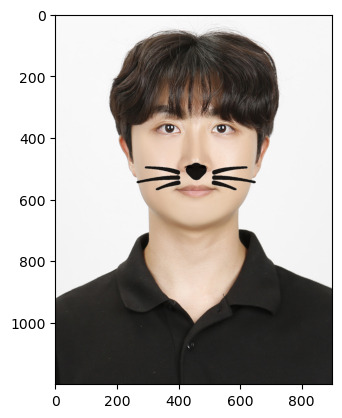

In [16]:
plt.imshow(cv2.cvtColor(img_bgr.copy(), cv2.COLOR_BGR2RGB)) 
plt.show()

음.... 안어울리는데...

# 2. 얼굴 절반 잘린 상태

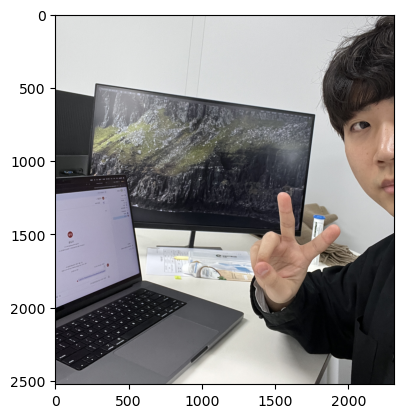

In [18]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/project/Exploration/Quest03/project_image/IMG1.jpg') 
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()     
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

rectangles[]


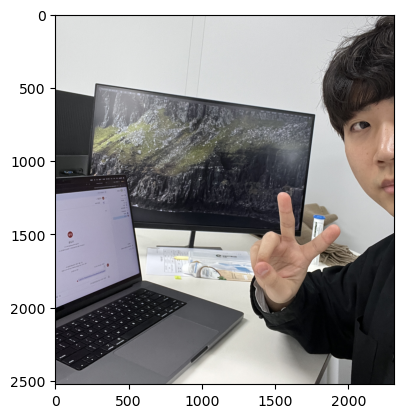

In [20]:
detector_hog = dlib.get_frontal_face_detector() 

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)

for dlib_rect in dlib_rects: 
    l = dlib_rect.left() 
    t = dlib_rect.top()
    r = dlib_rect.right() 
    b = dlib_rect.bottom() 

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

이 모델로는 적용이 안된다

# 3. 옆모습

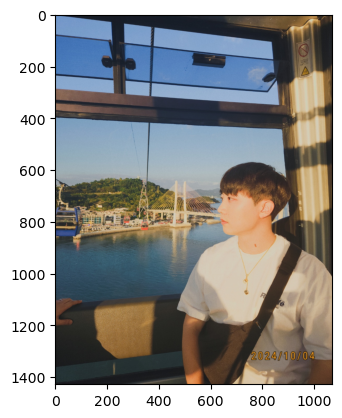

In [22]:
home_dir = os.getenv('HOME')
my_image_path = os.path.join(home_dir, 'work/project/Exploration/Quest03/project_image/IMG2.JPG') 
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()     
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

rectangles[]


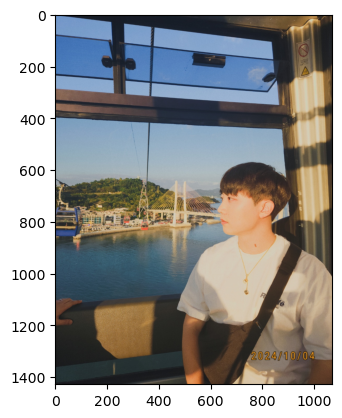

In [23]:
detector_hog = dlib.get_frontal_face_detector() 

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) 
dlib_rects = detector_hog(img_rgb, 1)
print(dlib_rects)

for dlib_rect in dlib_rects: 
    l = dlib_rect.left() 
    t = dlib_rect.top()
    r = dlib_rect.right() 
    b = dlib_rect.bottom() 

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

역시 인식이 안된다.

모델 자체가 정면 얼굴 데이터셋을 학습한 모델이기도 하고, 얼굴이 회전되어있거나 절반만 보이는 경우 gradient 패턴이 전혀 달라져서 안되는 거 같아보인다.

In [24]:
# Quest03/CV 1 파일에서도 말했지만, 실제 노드 학습 시 사용한 사진과
# 내가 사용한 사진과 다르기에, 왕관 씌우는 위치 계산이 전혀 다르다.
# 이는 촬영위치나 각도에 따라 달라지는거다. (한 사진으로만 일반화가 불가능)